In [1]:
!pip install imgaug                     # for image augmentation

In [2]:
!pip install -U segmentation-models    #for Dice metric and Iou Metric Computation

     |████████████████████████████████| 51kB 7.5MB/s 


In [3]:
import glob
import pandas  as pd
import numpy   as np
import nibabel as nib
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
from zipfile import ZipFile
from shutil import copyfile, copyfileobj
import gzip
from IPython.display import clear_output
import cv2
import os
from pylab import rcParams
import PIL
from PIL import Image
import scipy
from google.colab import files
from sklearn.model_selection import train_test_split
from google.colab import drive
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, MeanShift
import imgaug as ia
import imgaug.augmenters as iaa

In [4]:
# !pip install q tensorflow==2.1             #downgraded to instal sm
# !pip install q keras==2.3.1

In [5]:
import sys
import random
import warnings

import math
import seaborn as sns; sns.set()
from keras.callbacks import Callback
from keras.losses import binary_crossentropy
from tqdm import tqdm_notebook, tnrange
from itertools import chain
from skimage.io import imread, imshow, concatenate_images
from skimage.transform import resize
from skimage.morphology import label

from keras.models import Model, load_model
from keras.layers import Input, BatchNormalization, Activation, Dense, Dropout
from keras.layers.core import Lambda, RepeatVector, Reshape
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D, GlobalMaxPool2D
from keras.layers.merge import concatenate, add
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, LearningRateScheduler
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras import backend as K
import joblib
import gc
# import segmentation_models as sm

In [6]:
!pip install kaggle

In [7]:
# taken username and key from JSON file
os.environ['KAGGLE_USERNAME'] = "harshwalia"    
os.environ['KAGGLE_KEY'] = "2d72fd594b2e141d8285316efff7a1f9" 

In [9]:
!kaggle datasets download -d andrewmvd/covid19-ct-scans

100% 1.03G/1.03G [00:19<00:00, 58.2MB/s]



Unzipping all the files

In [10]:
with ZipFile('covid19-ct-scans.zip', 'r') as zipObj:
   # Extract all the contents of zip file in current directory
   zipObj.extractall('covid19-ct-scans')

In [11]:
pwd

'/content'

In [12]:
os.listdir('/content')

['.config', 'drive', 'covid19-ct-scans', 'covid19-ct-scans.zip', 'sample_data']

In [13]:
data = pd.read_csv('/content/covid19-ct-scans/metadata.csv')
data = data.replace('../input/covid19-ct-scans/','/content/covid19-ct-scans/',regex=True)
data.head(5)

ct_scan  ...                            lung_and_infection_mask
0  /content/covid19-ct-scans/ct_scans/coronacases...  ...  /content/covid19-ct-scans/lung_and_infection_m...
1  /content/covid19-ct-scans/ct_scans/coronacases...  ...  /content/covid19-ct-scans/lung_and_infection_m...
2  /content/covid19-ct-scans/ct_scans/coronacases...  ...  /content/covid19-ct-scans/lung_and_infection_m...
3  /content/covid19-ct-scans/ct_scans/coronacases...  ...  /content/covid19-ct-scans/lung_and_infection_m...
4  /content/covid19-ct-scans/ct_scans/coronacases...  ...  /content/covid19-ct-scans/lung_and_infection_m...

[5 rows x 4 columns]

In [14]:
np.array(data['ct_scan'])

array(['/content/covid19-ct-scans/ct_scans/coronacases_org_001.nii',
       '/content/covid19-ct-scans/ct_scans/coronacases_org_002.nii',
       '/content/covid19-ct-scans/ct_scans/coronacases_org_003.nii',
       '/content/covid19-ct-scans/ct_scans/coronacases_org_004.nii',
       '/content/covid19-ct-scans/ct_scans/coronacases_org_005.nii',
       '/content/covid19-ct-scans/ct_scans/coronacases_org_006.nii',
       '/content/covid19-ct-scans/ct_scans/coronacases_org_007.nii',
       '/content/covid19-ct-scans/ct_scans/coronacases_org_008.nii',
       '/content/covid19-ct-scans/ct_scans/coronacases_org_009.nii',
       '/content/covid19-ct-scans/ct_scans/coronacases_org_010.nii',
       '/content/covid19-ct-scans/ct_scans/radiopaedia_org_covid-19-pneumonia-10_85902_1-dcm.nii',
       '/content/covid19-ct-scans/ct_scans/radiopaedia_org_covid-19-pneumonia-10_85902_3-dcm.nii',
       '/content/covid19-ct-scans/ct_scans/radiopaedia_org_covid-19-pneumonia-14_85914_0-dcm.nii',
       '/cont

# Exploring the Dataset

In [15]:
ct_scan_path=[]
lung_mask_path=[]
infection_mask_path=[]
both_mask_path=[]

In [16]:
ct_scan_path=np.array(data['ct_scan'])
lung_mask_path=np.array(data['lung_mask'])
infection_mask_path=np.array(data['infection_mask'])
both_mask_path=np.array(data['lung_and_infection_mask'])

In [17]:
ct_scan_path[0]

'/content/covid19-ct-scans/ct_scans/coronacases_org_001.nii'

In [18]:
def plot_sample(array_list, color_map = 'nipy_spectral'):
    fig = plt.figure(figsize=(18,15))

    plt.subplot(1,4,1)
    plt.imshow(array_list[0], cmap='bone')
    plt.title('Original Image')
    plt.grid(None) 

    plt.subplot(1,4,2)
    plt.imshow(array_list[0], cmap='bone')
    plt.imshow(array_list[1], alpha=0.5, cmap=color_map)
    plt.title('Lung Mask')
    plt.grid(None)

    plt.subplot(1,4,3)
    plt.imshow(array_list[0], cmap='bone')
    plt.imshow(array_list[2], alpha=0.5, cmap=color_map)
    plt.title('Infection Mask')
    plt.grid(None)

    plt.subplot(1,4,4)
    plt.imshow(array_list[0], cmap='bone')
    plt.imshow(array_list[2], alpha=0.5, cmap=color_map)
    plt.title('Lung and Infection Mask')
    plt.grid(None)

    plt.show()

In [19]:
def enhanced_img(test_img,visualize):
  test_img = test_img*255
  test_img = np.uint8(test_img)
  clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8,8))
  clahe_image = clahe.apply(test_img)     # parameter passed must be of dtype uint8

  if(visualize==1):
    fig = plt.figure(figsize=(12,15))
    plt.subplot(1, 2, 1)
    plt.imshow(test_img, cmap='bone')
    plt.title("Original CT-Scan")
    plt.grid(None)
  
    plt.subplot(1,2,2)
    plt.imshow(clahe_image, cmap='bone')
    plt.title("Enhanced CT-Scan")
    plt.grid(None)
    
  return clahe_image   

* First Tried Manually cropping the image but it doesn't work out .
* So, now cropping the image using contours.
* From Lung mask Take contour along left lung and crop the img of left lung.
* Then from the 2nd Lung, take contour along the second Lung and crop it.
* Finally combine the both Cropped images to get the final croppped img.
* Now store the contours points because to Crop the Ctscan and mask corresponding to each Ctscan.

In [20]:
def cropped_img(test_img,visualize):
  test_img=test_img*255
  test_img=np.uint8(test_img)
  
  contours,hierarchy = cv2.findContours(test_img, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
  contours = sorted(contours, key=cv2.contourArea, reverse=True)
  #print(len(contours)) size=2 for both lungs

  lung1_pt=[]
  lung2_pt=[]

  # left lung
  cnt1=contours[0]  
  x,y,w,z=cv2.boundingRect(cnt1)
  crp_1=test_img[y:y+z,x:x+w]
  crp_1 = cv2.resize(crp_1, dsize=(125,250), interpolation=cv2.INTER_AREA)     
  lung1_pt.append(x);lung1_pt.append(y);lung1_pt.append(w);lung1_pt.append(z);

  crp_2=crp_1
  #Right lung
  if(len(contours)==2):
    cnt2=contours[1]
    p,q,r,s=cv2.boundingRect(cnt2)
    crp_2=test_img[q:q+s,p:p+r]
    crp_2 = cv2.resize(crp_2, dsize=(125,250), interpolation=cv2.INTER_AREA)
    lung2_pt.append(p);lung2_pt.append(q);lung2_pt.append(r);lung2_pt.append(s);
  else:
    lung2_pt.append(x);lung2_pt.append(y);lung2_pt.append(w);lung2_pt.append(z);
    # before merging two image dimensions of 2 image must be same
  ROI = np.concatenate((crp_1, crp_2), axis=1)  

  if(visualize==1):
    fig = plt.figure(figsize=(10,8))
    plt.subplot(1,3,1)
    plt.imshow(crp_1)
    plt.grid(None)

    plt.subplot(1,3,2)
    plt.imshow(crp_2)
    plt.grid(None)

    plt.subplot(1,3,3)
    plt.imshow(ROI)
    plt.grid(None)

    plt.show()
  
  return (ROI,lung1_pt,lung2_pt)



In [21]:
img_size=512

In [22]:
def read_nii(filepath,img_arr):
    ct_scan = nib.load(filepath)
    array   = ct_scan.get_fdata()
    array   = np.rot90(np.array(array))
    slices = array.shape[2]
    #get the slices between 25% and 75%
    array=array[:,:,round(slices*0.25):round(slices*0.75)]
    array=np.reshape(np.rollaxis(array,2),(array.shape[2],array.shape[1],array.shape[0],1))

    for img_no in range(0,array.shape[0]):
      # all images need to be of same size before further preprocessing
      img=cv2.resize(array[img_no], dsize=(img_size, img_size), interpolation=cv2.INTER_AREA)
      # Normalising all the images
      xmax,xmin=img.max(),img.min()
      img=(img-xmin)/(xmax-xmin)
      img_arr.append(img)


In [23]:
cts=[]
lungs=[]

In [24]:
for i in range(0, 20):
    read_nii(data.loc[i,'lung_mask'], lungs)
    read_nii(data.loc[i,'ct_scan'], cts) 

In [25]:
print(len(cts), len(lungs))

1766 1766


In [26]:
# To store the cropped ct and cropped lungs
new_cts = []
new_lungs = []

In [27]:
for img_no in range(len(lungs)):

    lung_img = lungs[img_no]
    lung_img[lung_img>0]=1   # Binary Lung Mask
    cropped_lung, points1, points2 = cropped_img(lung_img, visualize = 0)
    new_lungs.append(cropped_lung)

    cts_img = cts[img_no]
    cts_img = enhanced_img(cts_img, visualize = 0)
    a,b,c,d = points1[0], points1[1], points1[2], points1[3]
    e,f,g,h = points2[0], points2[1], points2[2], points2[3]
    img1 = cts_img[b:b+d, a:a+c]
    img1 = cv2.resize(img1, dsize=(125,250), interpolation=cv2.INTER_AREA)
    img2 = cts_img[f:f+h, e:e+g]
    img2 = cv2.resize(img2, dsize=(125,250), interpolation=cv2.INTER_AREA)
    cropped_cts = np.concatenate((img1, img2), axis=1)   # final cropped ct
    new_cts.append(cropped_cts)

In [28]:
print(len(new_cts), len(new_lungs))

1766 1766


(512, 512) (512, 512)


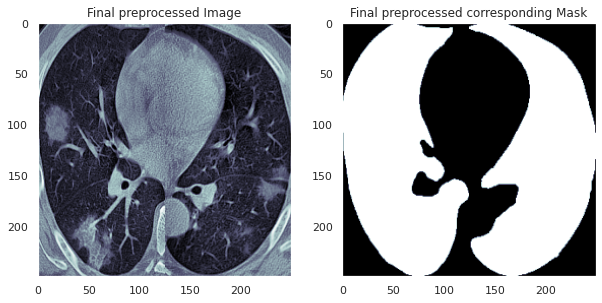

In [29]:
index = 200

rcParams['figure.figsize'] = 10,10

plt.subplot(1, 2, 1)
plt.imshow(new_cts[index], cmap='bone')
plt.title("Final preprocessed Image")
plt.grid(None)

plt.subplot(1, 2, 2)
plt.imshow(new_lungs[index], cmap='bone')
plt.title("Final preprocessed corresponding Mask")
plt.grid(None)

print(cts[index].shape, lungs[index].shape)

* Some of them Masks are complete Black we remove those black Masks to pass the rest of the images from segmentation Model to Segment the infection.
* In Segmentation model we have to only pass the masks which are not completely Black.

In [30]:
complete_black_masks = []
for i in range(0, len(lungs)):
  if np.unique(lungs[i]).size == 1:
    complete_black_masks.append(i)
print("Number of complete black masks :" , len(complete_black_masks))

Number of complete black masks : 0


But Here we found 0 number of blank masks because we have earlier removed all the faulty images so no blank mask in lungs is there.

* After cropping change the dimensions of all images to same size.
* Used median of the all width and height but couldn't fit the RAM so   reduced the size to 224, though images with larger resolution with more clear features will possibly give better results on the same model.

In [31]:
dim1=[]
dim2=[]
for i in range(0, len(cts)):
  dim1.append(new_cts[i].shape[0])
  dim2.append(new_cts[i].shape[1])
dim1 = np.array(dim1)
dim2 = np.array(dim2)

print("New net dimension to which all must be resized to (some will increase and some decrease) --->", np.median(dim1),'x', np.median(dim2))

New net dimension to which all must be resized to (some will increase and some decrease) ---> 250.0 x 250.0


In [17]:
new_dim = 128

In [33]:
for i in range(0,len(new_cts)):
  new_cts[i] = cv2.resize(new_cts[i], dsize=(new_dim, new_dim), interpolation=cv2.INTER_LINEAR)
  new_lungs[i] = cv2.resize(new_lungs[i], dsize=(new_dim, new_dim), interpolation=cv2.INTER_LINEAR)
  

In [34]:
type(new_cts)

list

In [35]:
new_cts = np.array(new_cts)
new_lungs = np.array(new_lungs)

In [36]:
type(new_cts)

numpy.ndarray

In [37]:
new_cts = np.uint8(new_cts)
new_lungs = np.uint8(new_lungs)

# Data Augmentation

In [38]:
sometimes = lambda aug: iaa.Sometimes(0.5, aug)

seq = iaa.Sequential([
    iaa.Fliplr(0.5), # horizontally flip 50% of all images
    iaa.Flipud(0.2), # vertically flip 20% of all images
    iaa.Sharpen(alpha=(0, 1.0), lightness=(0.80, 1.5)),
    iaa.LinearContrast((0.90, 1.5)),
    sometimes(iaa.Affine(
            scale={"x": (0.8, 1.2), "y": (0.8, 1.2)}, # scale images to 80-120% of their size, individually per axis
            translate_percent={"x": (-0.2, 0.2), "y": (-0.2, 0.2)}, # translate by -20 to +20 percent (per axis)
            rotate=(-30, 30), # rotate by -30 to +30 degrees
        ))
], random_order=True)

In [39]:
no_of_aug_imgs = 50
random_indices = np.random.randint(0, new_cts.shape[0], size=no_of_aug_imgs)
sample_new_cts = new_cts[random_indices]
sample_new_lungs = new_lungs[random_indices]

In [40]:
new_cts_aug=seq(images=sample_new_cts)
new_lungs_aug=seq(images=sample_new_lungs)

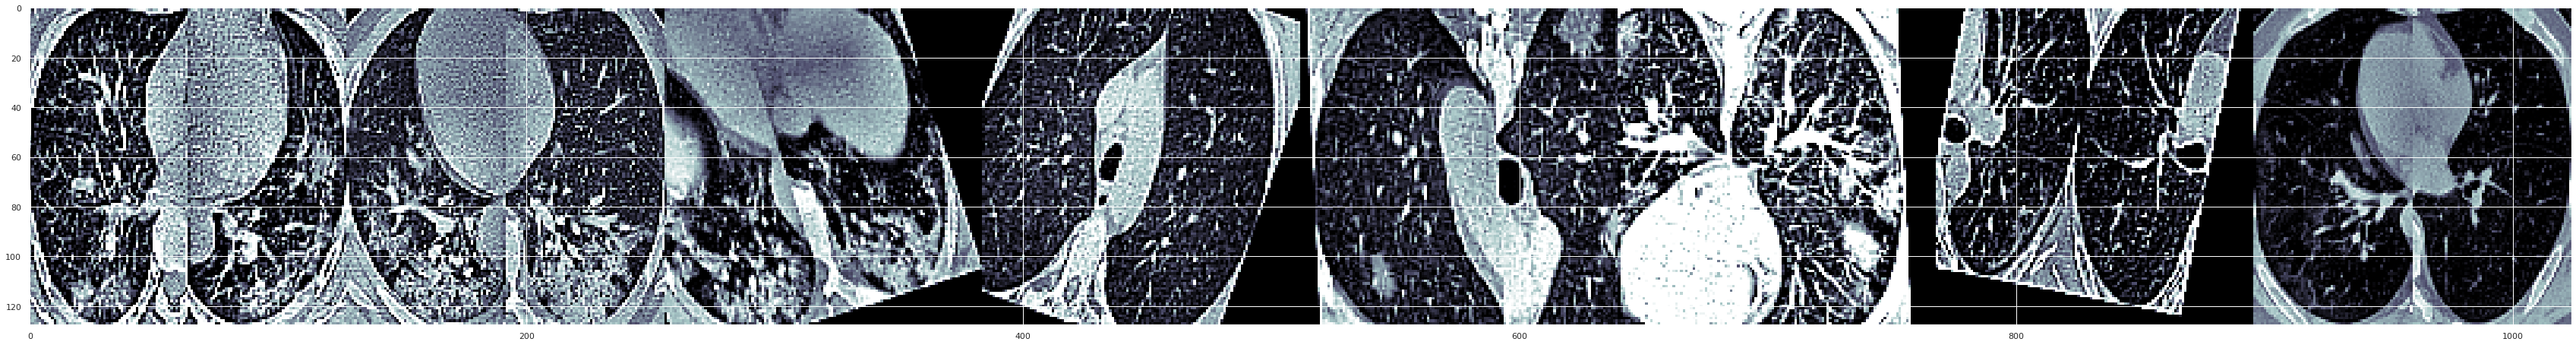

In [41]:
rcParams['figure.figsize'] = 60,60
rand = np.random.randint(0, no_of_aug_imgs, size=8)

cells1 = new_cts_aug[rand]
grid_image1 = np.hstack(cells1)
plt.imshow(grid_image1, cmap = 'bone')

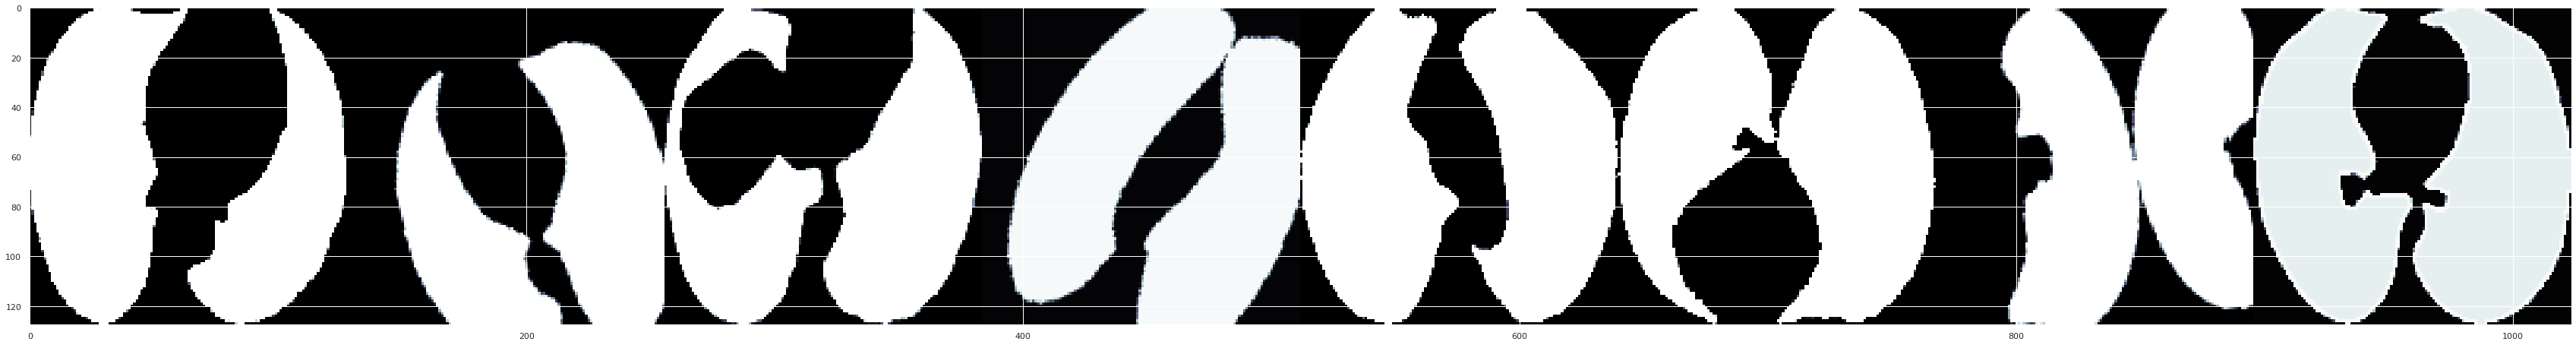

In [42]:
cells2 = new_lungs_aug[rand]
grid_image2 = np.hstack(cells2)
plt.imshow(grid_image2, cmap = 'bone')

In [43]:
print(new_cts_aug.shape, new_lungs_aug.shape)

(50, 128, 128) (50, 128, 128)


In [44]:
new_cts = np.concatenate((new_cts, new_cts_aug), axis=0)
new_lungs = np.concatenate((new_lungs, new_lungs_aug), axis = 0)
print(new_cts.shape, new_lungs.shape)

(1816, 128, 128) (1816, 128, 128)


In [45]:
print(new_cts.min())
print(new_cts.max())

0
255


Normalising the images

In [46]:
new_cts=(new_cts-new_cts.min())/(new_cts.max()-new_cts.min())
new_lungs=(new_lungs-new_lungs.min())/(new_lungs.max()-new_lungs.min())

In [47]:
print(new_cts.min())
print(new_cts.max())

0.0
1.0


In [48]:
new_cts = new_cts.reshape(len(new_cts), new_dim, new_dim, 1)
new_lungs = new_lungs.reshape(len(new_lungs), new_dim, new_dim, 1)

In [49]:
print(len(new_cts), len(new_lungs))

1816 1816


In [49]:
# Loading the new_cts and new_lungs from drive

In [9]:
new_cts=joblib.load('/content/drive/My Drive/cts and infections/new_cts_cropped_lungs_128.pkl')
new_lungs=joblib.load('/content/drive/My Drive/cts and infections/new_lungs_cropped_lungs_128.pkl')

Overlaying LUNG masks over the corresponding CT scans

In [10]:
def plot_processed_sample(array_list, color_map = 'nipy_spectral'):
   
    fig = plt.figure(figsize=(10,8))

    plt.subplot(1,2,1)
    plt.imshow(array_list[0].reshape(new_dim, new_dim), cmap='bone')
    plt.title('Original Image')
    plt.grid(None)


    plt.subplot(1,2,2)
    plt.imshow(array_list[0].reshape(new_dim, new_dim))
    plt.imshow(array_list[1].reshape(new_dim, new_dim), alpha=0.5, cmap=color_map)
    plt.title('Lung Mask')
    plt.grid(None)

    plt.show()

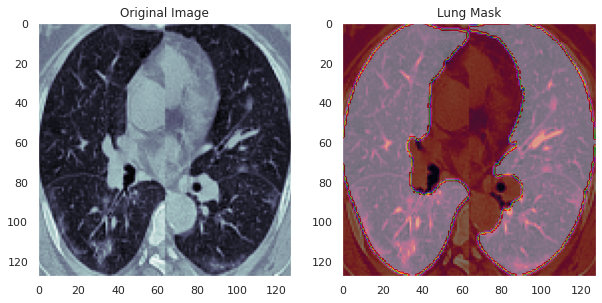

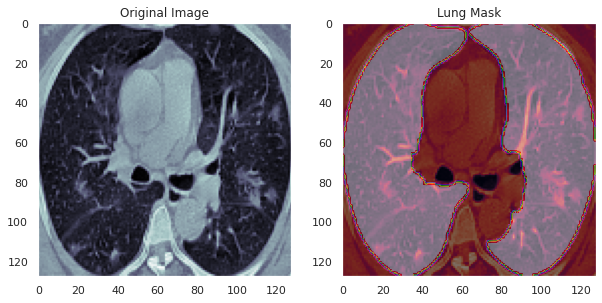

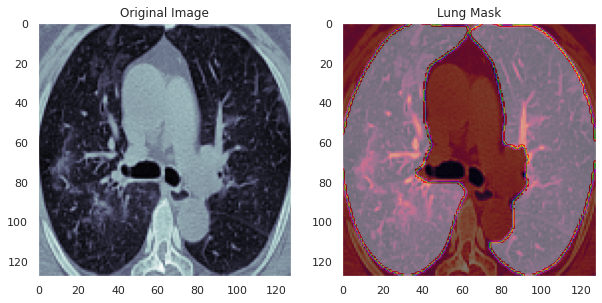

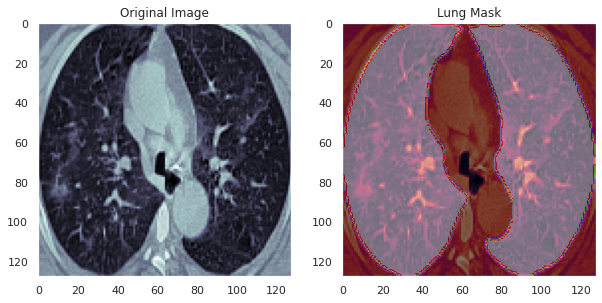

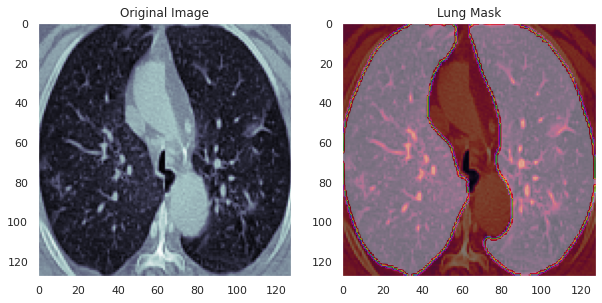

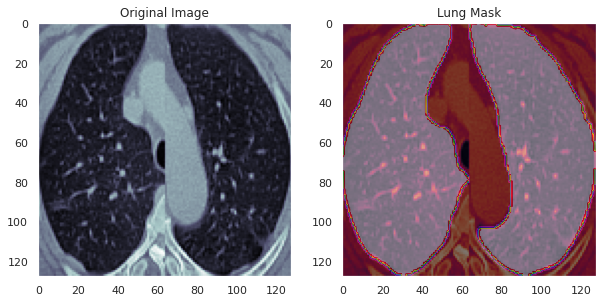

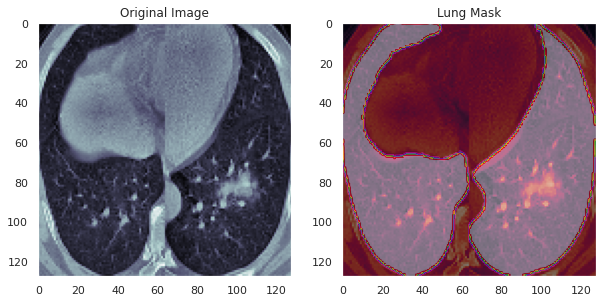

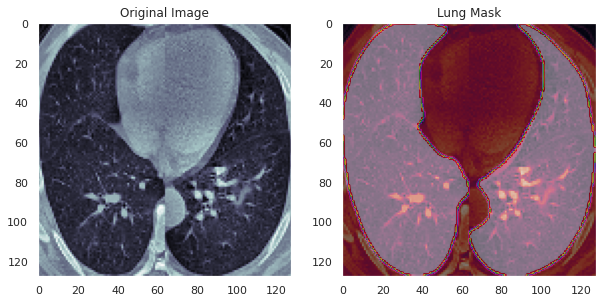

In [18]:
for index in [90,110,120,135,140,150,170,180]:
    plot_processed_sample([new_cts[index], new_lungs[index]])

Splitting of the data into Train and Test set

In [12]:
x_train,x_valid,y_train,y_valid=train_test_split(new_cts,new_lungs,test_size=0.3,random_state=42)

In [13]:
print(x_train.shape, x_valid.shape)

(1271, 128, 128, 1) (545, 128, 128, 1)


# Loss function and Metrics

In [14]:
# Basically we use the smooth to avoid division by 0.
def iou_coef(y_true, y_pred, smooth=1):
  intersection = K.sum(K.abs(y_true * y_pred), axis=[1,2,3])
  union = K.sum(y_true,[1,2,3])+K.sum(y_pred,[1,2,3])-intersection
  iou = K.mean((intersection + smooth) / (union + smooth), axis=0)
  return iou

def dice_coeff(y_true, y_pred,smooth=1):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    score = (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
    return score

def dice_loss(y_true, y_pred):
    loss = 1 - dice_coeff(y_true, y_pred)
    return loss

def bce_dice_loss(y_true, y_pred):
    loss = 0.5*binary_crossentropy(y_true, y_pred) + 0.5*dice_loss(y_true, y_pred)
    return loss

        

# UNET Model

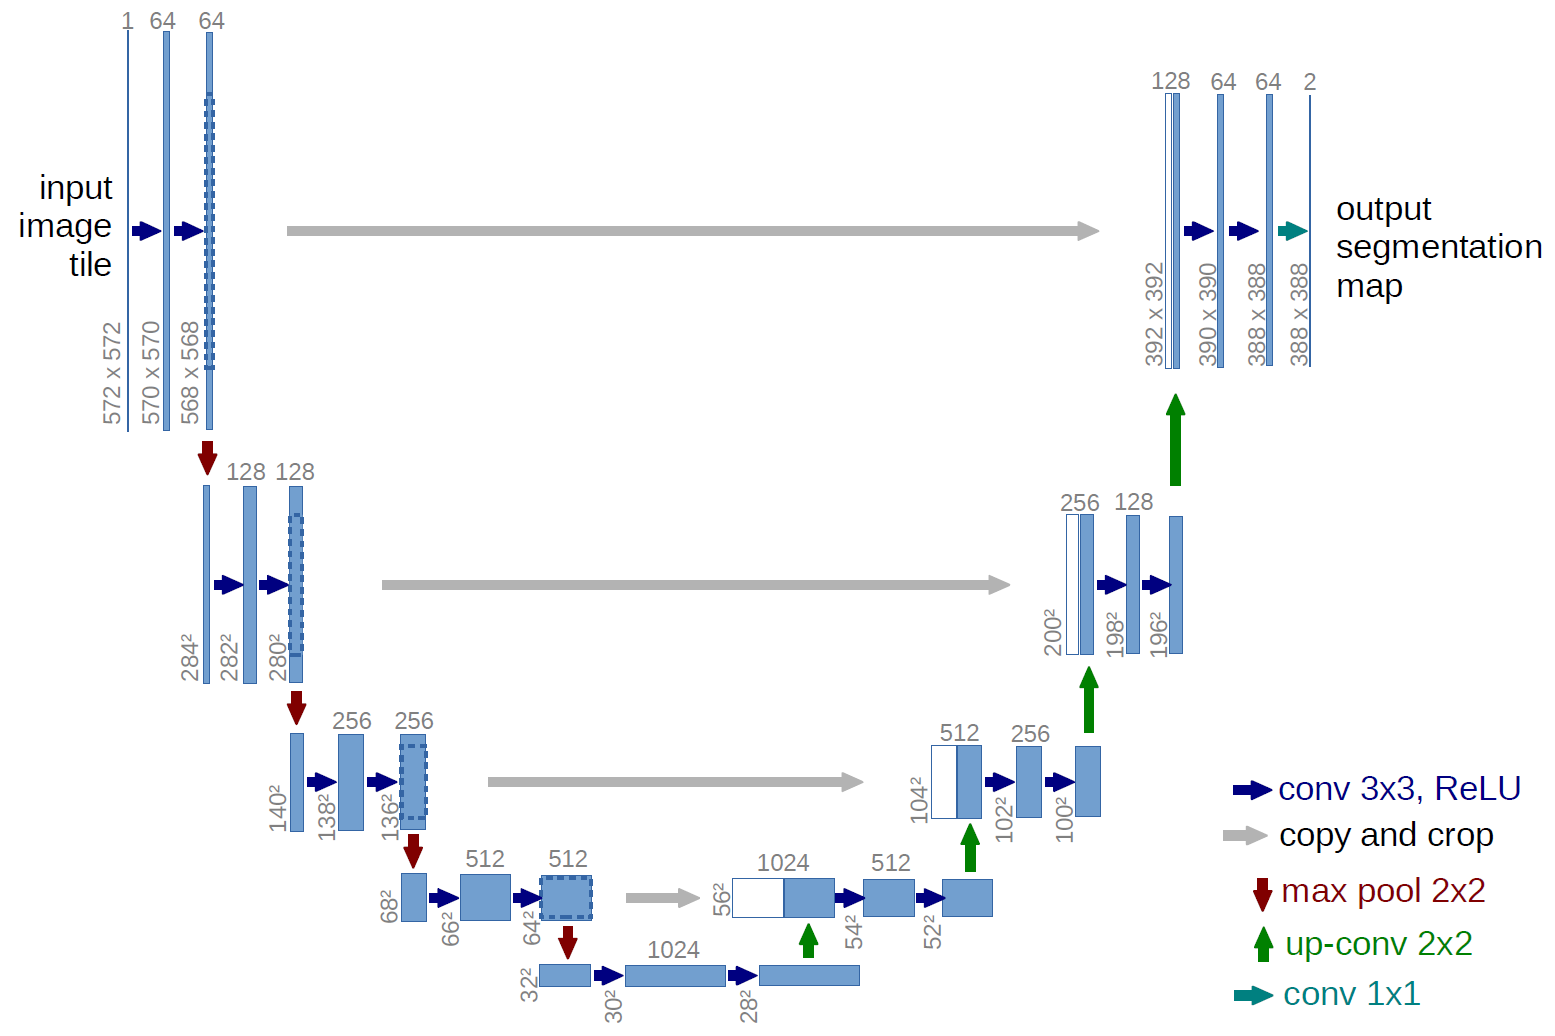


Constructing the Unet Model from the above image.

In [19]:
# After preprocessing convert all images to same dimensons i.e new_dim to feed into Unet
inputs = Input((new_dim, new_dim, 1))

    
c1 = Conv2D(32, (3, 3), activation='relu', padding='same', kernel_initializer="he_normal") (inputs)
c1 = Conv2D(32, (3, 3), activation='relu', padding='same', kernel_initializer="he_normal") (c1)
c1 = BatchNormalization()(c1)
p1 = MaxPooling2D((2, 2)) (c1)
p1 = Dropout(0.25)(p1)

c2 = Conv2D(64, (3, 3), activation='relu', padding='same', kernel_initializer="he_normal") (p1)
c2 = Conv2D(64, (3, 3), activation='relu', padding='same', kernel_initializer="he_normal") (c2)
c2 = BatchNormalization()(c2)
p2 = MaxPooling2D((2, 2)) (c2)
p2 = Dropout(0.25)(p2)

c3 = Conv2D(128, (3, 3), activation='relu', padding='same', kernel_initializer="he_normal") (p2)
c3 = Conv2D(128, (3, 3), activation='relu', padding='same', kernel_initializer="he_normal") (c3)
c3 = BatchNormalization()(c3)
p3 = MaxPooling2D((2, 2)) (c3)
p3 = Dropout(0.25)(p3)

c4 = Conv2D(256, (3, 3), activation='relu', padding='same', kernel_initializer="he_normal") (p3)
c4 = Conv2D(256, (3, 3), activation='relu', padding='same', kernel_initializer="he_normal") (c4)
c4 = BatchNormalization()(c4)
p4 = MaxPooling2D(pool_size=(2, 2)) (c4)
p4 = Dropout(0.25)(p4)

c5 = Conv2D(512, (3, 3), activation='relu', padding='same', kernel_initializer="he_normal") (p4)
c5 = Conv2D(512, (3, 3), activation='relu', padding='same', kernel_initializer="he_normal") (c5)

u6 = Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(c5)
u6 = concatenate([u6, c4])
u6 = BatchNormalization()(u6)
c6 = Conv2D(256, (3, 3), activation='relu', padding='same', kernel_initializer="he_normal") (u6)
c6 = Conv2D(256, (3, 3), activation='relu', padding='same', kernel_initializer="he_normal") (c6)


u7 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same') (c6)
u7 = concatenate([u7, c3])
u7 = BatchNormalization()(u7)
c7 = Conv2D(128, (3, 3), activation='relu', padding='same', kernel_initializer="he_normal") (u7)
c7 = Conv2D(128, (3, 3), activation='relu', padding='same', kernel_initializer="he_normal") (c7)


u8 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same') (c7)
u8 = concatenate([u8, c2])
u8 = BatchNormalization()(u8)
c8 = Conv2D(64, (3, 3), activation='relu', padding='same', kernel_initializer="he_normal") (u8)
c8 = Conv2D(64, (3, 3), activation='relu', padding='same', kernel_initializer="he_normal") (c8)


u9 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same') (c8)
u9 = concatenate([u9, c1], axis=3)
u9 = BatchNormalization()(u9)
c9 = Conv2D(32, (3, 3), activation='relu', padding='same', kernel_initializer="he_normal") (u9)
c9 = Conv2D(32, (3, 3), activation='relu', padding='same', kernel_initializer="he_normal") (c9)

outputs = Conv2D(1, (1, 1), activation='sigmoid') (c9)

model = Model(inputs=[inputs], outputs=[outputs])
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 1) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 128, 128, 32) 320         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 128, 128, 32) 9248        conv2d[0][0]                     
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 128, 128, 32) 128         conv2d_1[0][0]                   
______________________________________________________________________________________________

In [20]:
batch_size = 32
epochs = 80
filepath_dice_coeff="unet_covid_weights_dice_coeff.hdf5"
filepath_loss = "unet_covid_weights_val_loss.hdf5"
checkpoint_dice = ModelCheckpoint(filepath_dice_coeff, monitor='val_dice_coeff', verbose=1, save_best_only=True, mode='max')
checkpoint_loss = ModelCheckpoint(filepath_loss, monitor='val_loss', verbose=1, save_best_only=True, mode='min')

Trains the model for a fixed number of epochs (iterations on a dataset).

In [20]:
model.compile(optimizer=Adam(lr = 0.0005), loss=bce_dice_loss, metrics=[dice_coeff])

In [ ]:
results = model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs,
                    validation_data=(x_valid, y_valid),
                    callbacks = [checkpoint_dice, checkpoint_loss])

Epoch 1/80
40/40 [==============================] - 21s 257ms/step - loss: 0.3345 - dice_coeff: 0.7565 - val_loss: 0.2156 - val_dice_coeff: 0.8564

Epoch 00001: val_dice_coeff improved from -inf to 0.85640, saving model to unet_covid_weights_dice_coeff.hdf5

Epoch 00001: val_loss improved from inf to 0.21562, saving model to unet_covid_weights_val_loss.hdf5
Epoch 2/80
40/40 [==============================] - 7s 164ms/step - loss: 0.0957 - dice_coeff: 0.9429 - val_loss: 0.9485 - val_dice_coeff: 0.3373

Epoch 00002: val_dice_coeff did not improve from 0.85640

Epoch 00002: val_loss did not improve from 0.21562
Epoch 3/80
40/40 [==============================] - 7s 165ms/step - loss: 0.0770 - dice_coeff: 0.9527 - val_loss: 0.8084 - val_dice_coeff: 0.5231

Epoch 00003: val_dice_coeff did not improve from 0.85640

Epoch 00003: val_loss did not improve from 0.21562
Epoch 4/80
40/40 [==============================] - 7s 165ms/step - loss: 0.0721 - dice_coeff: 0.9556 - val_loss: 0.4006 - val_d

Model saved in json format and its weight in .hdf5 format at local

Keras saves models by inspecting their architectures. This technique saves everything:

* The weight values
* The model's architecture
* The model's training configuration (what you pass to the .compile() method)
* The optimizer and its state, if any (this enables you to restart training where you left off)

In [ ]:
model.load_weights(filepath_dice_coeff)

In [ ]:
model.save_weights('unet_lung_segmentation_0.9755.h5')

In [ ]:
files.download('unet_lung_segmentation_0.9755.h5')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
model_json = model.to_json()
with open("unet_lung_segmentation_0.9755.json","w") as json_file:
     json_file.write(model_json)

files.download("unet_lung_segmentation_0.9755.json")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

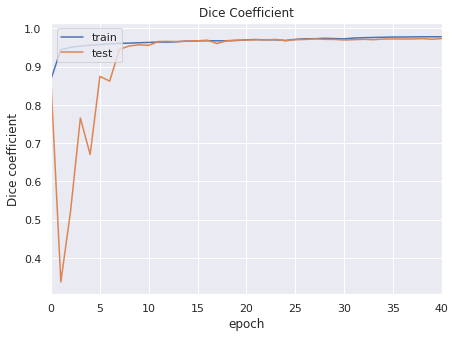

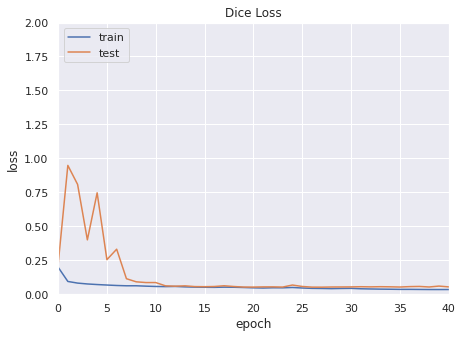

In [ ]:
plt.rcParams["axes.grid"] = True
rcParams['figure.figsize'] = 7, 5
plt.xlim(0, 40)
plt.plot(results.history['dice_coeff'])
plt.plot(results.history['val_dice_coeff'])
plt.title('Dice Coefficient')
plt.ylabel('Dice coefficient')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.ylim(0, 2)
plt.xlim(0, 40)
plt.plot(results.history['loss'])
plt.plot(results.history['val_loss'])
plt.title('Dice Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
plt.rcParams["axes.grid"] = False

In [ ]:
def compare_actual_and_predicted(image_no):
    temp = model.predict(new_cts[image_no].reshape(1,new_dim, new_dim, 1))

    fig = plt.figure(figsize=(15,15))

    plt.subplot(1,3,1)
    plt.imshow(new_cts[image_no].reshape(new_dim, new_dim), cmap='bone')
    plt.title('Original Image (CT)')

    plt.subplot(1,3,2)
    plt.imshow(new_lungs[image_no].reshape(new_dim,new_dim))
    plt.title('Actual mask')

    plt.subplot(1,3,3)
    plt.imshow(temp.reshape(new_dim,new_dim))
    plt.title('Predicted mask')

    plt.show()
    

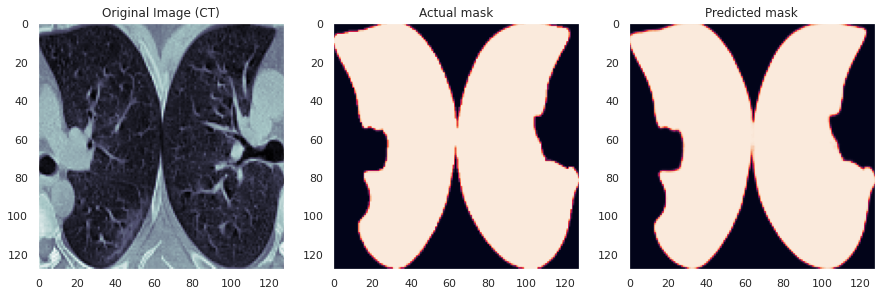

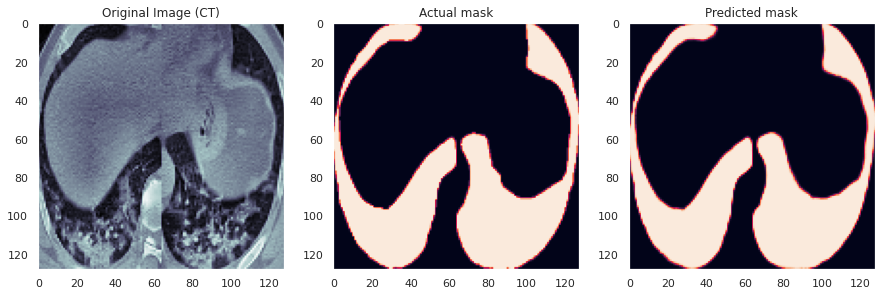

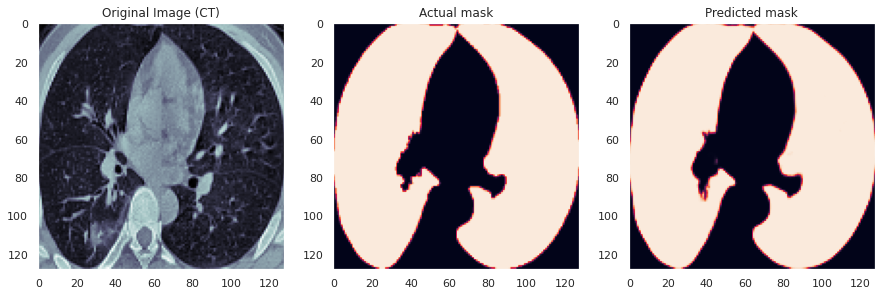

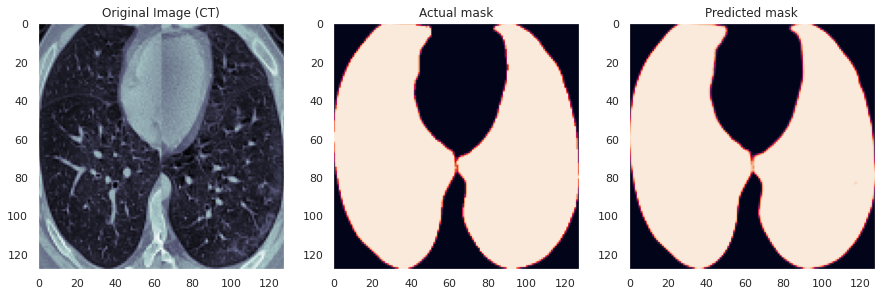

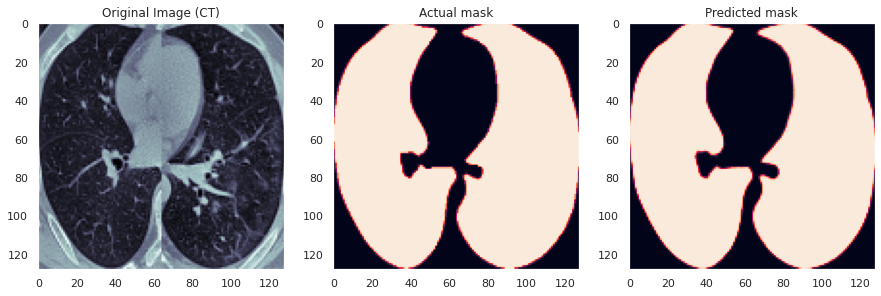

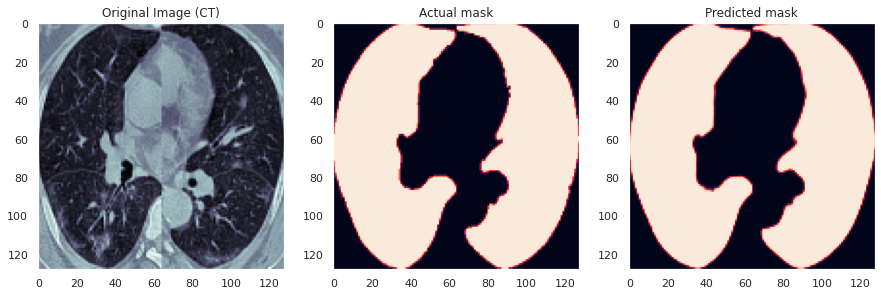

In [ ]:
for i in [440,269,555, 355, 380, 90]:
    compare_actual_and_predicted(i)

In [39]:
score = model.evaluate(x_valid, y_valid, batch_size=32)
print("test loss, test dice coefficient:", score)

18/18 [==============================] - 0s 25ms/step - loss: 0.0584 - precision: 0.9923 - recall: 0.9430
test loss, test dice coefficient: [0.05835236236453056, 0.9923283457756042, 0.9429988861083984]


# post Processing

In [8]:
drive.mount('/content/drive')

Mounted at /content/drive


In [21]:
# model.load_weights(filepath_dice_coeff)
model.load_weights('/content/drive/My Drive/cts and infections/unet_lung_segmentation_0.9755.h5')

In [22]:
%env SM_FRAMEWORK=tf.keras

env: SM_FRAMEWORK=tf.keras


In [23]:
import segmentation_models as sm

Segmentation Models: using `tf.keras` framework.


In [24]:
threshold_range = np.arange(0.10,0.80, 0.05)

In [25]:
print(threshold_range)

[0.1  0.15 0.2  0.25 0.3  0.35 0.4  0.45 0.5  0.55 0.6  0.65 0.7  0.75]


In [26]:
dices=[]
ious=[]
#Testing for different Threshold values
for t in threshold_range:
  iou=sm.metrics.IOUScore(threshold=t)   # Returns:	A callable iou_score instance. Can be used in model.compile(...) function.
  dice = sm.metrics.FScore(threshold=t)  # Returns: A callable f_score instance. Can be used in model.compile(...) function.
  model.compile(optimizer=Adam(lr=0.0005),loss=bce_dice_loss,metrics=[dice,iou])
  score=model.evaluate(x_valid,y_valid,batch_size=32)
  dices.append(score[1])
  ious.append(score[2])

18/18 [==============================] - 1s 40ms/step - loss: 0.0521 - f1-score: 0.9785 - iou_score: 0.9580


In [27]:
print('DICES:',dices)
print("IOUS:",ious)
print("Best Threshold:", threshold_range[np.argmax(dices)])
print("Best dice score:", dices[np.argmax(dices)])
print("Best iou score:", ious[np.argmax(ious)])

DICES: [0.9748232364654541, 0.9763934016227722, 0.9773234128952026, 0.9779012203216553, 0.9783225655555725, 0.978590726852417, 0.9787299036979675, 0.978783369064331, 0.9787232875823975, 0.9785811305046082, 0.9783341288566589, 0.977971076965332, 0.9774670004844666, 0.976745069026947]
IOUS: [0.9509801864624023, 0.9539721012115479, 0.9557490944862366, 0.9568541049957275, 0.9576621651649475, 0.9581769108772278, 0.9584439396858215, 0.9585477113723755, 0.9584330320358276, 0.9581620097160339, 0.9576900005340576, 0.9569960832595825, 0.956034243106842, 0.9546583890914917]
Best Threshold: 0.45000000000000007
Best dice score: 0.978783369064331
Best iou score: 0.9585477113723755


Best Threshold: 0.45000000000000007


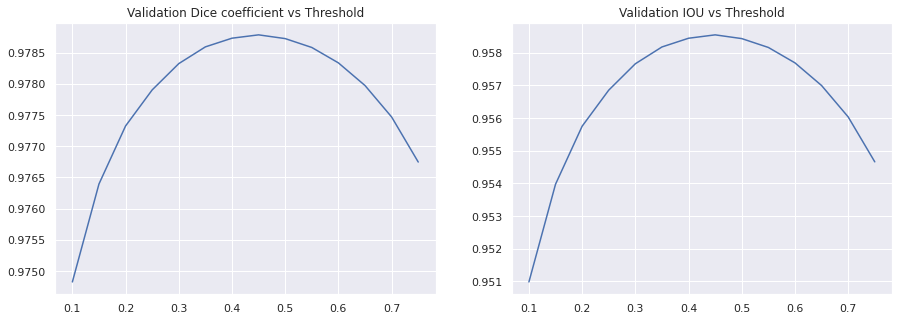

In [28]:
print("Best Threshold:", threshold_range[np.argmax(dices)])
fig = plt.figure(figsize=(15,5))

plt.subplot(1, 2, 1)
plt.plot(threshold_range, dices)
plt.title("Validation Dice coefficient vs Threshold")

plt.subplot(1, 2, 2)
plt.plot(threshold_range, ious)
plt.title("Validation IOU vs Threshold")

plt.show()

In [28]:
the_new_range = np.arange(0.43,0.49, 0.001)

In [29]:
print(the_new_range)

[0.43  0.431 0.432 0.433 0.434 0.435 0.436 0.437 0.438 0.439 0.44  0.441
 0.442 0.443 0.444 0.445 0.446 0.447 0.448 0.449 0.45  0.451 0.452 0.453
 0.454 0.455 0.456 0.457 0.458 0.459 0.46  0.461 0.462 0.463 0.464 0.465
 0.466 0.467 0.468 0.469 0.47  0.471 0.472 0.473 0.474 0.475 0.476 0.477
 0.478 0.479 0.48  0.481 0.482 0.483 0.484 0.485 0.486 0.487 0.488 0.489]


In [ ]:
new_dices=[]
new_ious=[]

for t in the_new_range:
  iou = sm.metrics.IOUScore(threshold=t)
  dice = sm.metrics.FScore(threshold=t)
  model.compile(optimizer=Adam(lr = 0.0005), loss=bce_dice_loss, metrics=[dice, iou])
  score = model.evaluate(x_valid, y_valid, batch_size=32)
  new_dices.append(score[1])
  new_ious.append(score[2])

18/18 [==============================] - 1s 40ms/step - loss: 0.0521 - f1-score: 0.9804 - iou_score: 0.9617


In [33]:
print("New Best Threshold:", the_new_range[np.argmax(new_dices)])
print("Best new dice score:", new_dices[np.argmax(new_dices)])
print("Best new iou score:", new_ious[np.argmax(new_ious)])

New Best Threshold: 0.459
Best new dice score: 0.978794515132904
Best new iou score: 0.9585694074630737


Best Threshold: 0.459


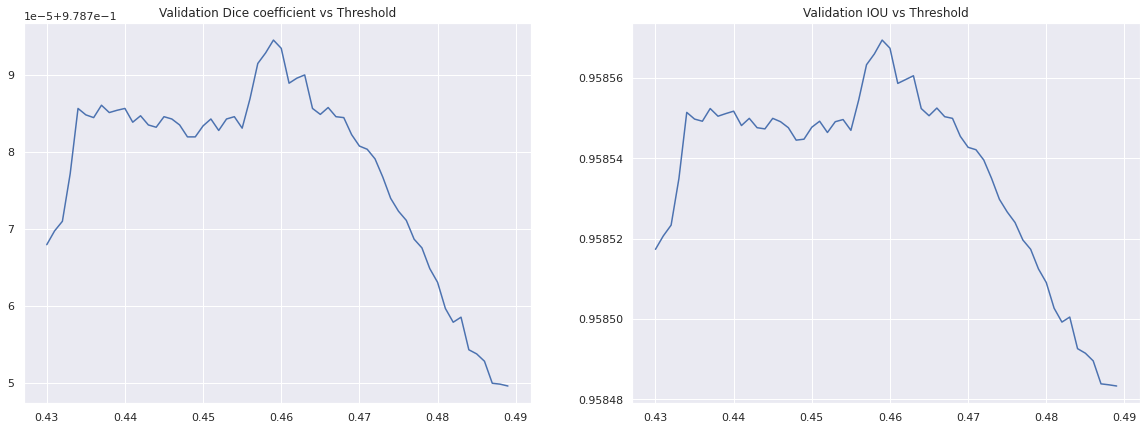

In [34]:
print("Best Threshold:", the_new_range[np.argmax(new_dices)])
fig = plt.figure(figsize=(20,7))

plt.subplot(1, 2, 1)
plt.plot(the_new_range, new_dices)
plt.title("Validation Dice coefficient vs Threshold")

plt.subplot(1, 2, 2)
plt.plot(the_new_range, new_ious)
plt.title("Validation IOU vs Threshold")

plt.show()

In [35]:
the_prec_rec_range = np.arange(0,1, 0.05)

In [36]:
precisions=[]
recalls=[]
new_dices=[]

for t in the_prec_rec_range:
  precision = sm.metrics.Precision(threshold=t)
  recall = sm.metrics.Recall(threshold=t)
  dice = sm.metrics.FScore(threshold=t)
  model.compile(optimizer=Adam(lr = 0.0005), loss=bce_dice_loss, metrics=[precision, recall,dice])
  score = model.evaluate(x_valid, y_valid, batch_size=32)
  precisions.append(score[1])
  recalls.append(score[2])
  new_dices.append(score[3])

18/18 [==============================] - 1s 41ms/step - loss: 0.0521 - precision: 0.9931 - recall: 0.9465 - f1-score: 0.9692


In [37]:
print("Best Threshold for dice:", the_prec_rec_range[np.argmax(new_dices)])
print("Best precision score:", precisions[np.argmax(new_dices)])
print("Best recall score:", recalls[np.argmax(new_dices)])
print("Best new dice score:", new_dices[np.argmax(new_dices)])

Best Threshold for dice: 0.45
Best precision score: 0.9774733781814575
Best recall score: 0.9801051616668701
Best new dice score: 0.978783369064331


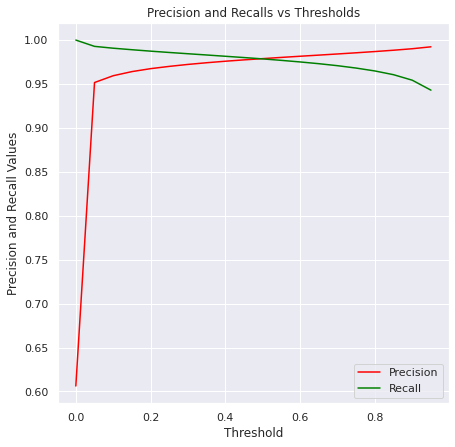

In [38]:
rcParams['figure.figsize'] = 7,7
plt.rcParams["axes.grid"] = True
plt.title("Precision and Recalls vs Thresholds")
plt.xlabel('Threshold')
plt.ylabel('Precision and Recall Values')
plt.plot(the_prec_rec_range,precisions, color='red')
plt.plot(the_prec_rec_range, recalls, color='green')
plt.legend(['Precision', 'Recall'])